<a href="https://colab.research.google.com/github/SEOYUNJE/Endoscope-Object-Detection/blob/main/Calibrated-Confidence-Score/gastroscopy_tf_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/seoyunje/gastroscopy-256x256-resized-png')
od.download('https://www.kaggle.com/datasets/msyu78/gastroscopy-meta')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/gastroscopy-256x256-resized-png


100%|██████████| 177M/177M [00:02<00:00, 73.1MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msyu78/gastroscopy-meta


100%|██████████| 802k/802k [00:00<00:00, 24.2MB/s]

## 1. Import Library
___

In [ ]:
!pip install -q colorama

In [ ]:
import os
from tqdm import tqdm

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from colorama import Fore

from glob import glob
import cv2
from PIL import Image

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K

os.environ["CUDA_IS_VISIBLE"] = '0,1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
   strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
   print(f'Using {len(gpus)} GPUs')
else:
   strategy = tf.distribute.MirroredStrategy()
   print(f'Using {len(gpus)} GPUs')

Using 1 GPUs


#### Configuration

In [ ]:
class CFG:
    output_dir = 'runs/classify'
    seed = 2025
    img_size = [256,256]

    fold = 0
    num_epochs = 10

    batch_size = 16
    drop_last = False

    label_smoothing = 0.05
    base_lr = 1e-3
    min_lr = 1e-9
    weight_decay = 1e-5

    amp = True
    ema = False

os.makedirs(CFG.output_dir, exist_ok=True)

#### Reproducibility

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(CFG.seed)

#### AMP: Auto Mixed Precision

In [ ]:
if CFG.amp:
   tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
   print('Mixed Precision Enabled')
else:
   print('Using full precision')

Mixed Precision Enabled


## 2. Road and Read Data
___

In [ ]:
df = pd.read_csv('/content/gastroscopy-meta/gastroscopy_data2.csv')

train_meta = pd.read_csv('/content/gastroscopy-256x256-resized-png/train_meta.csv')
train_id = train_meta['image_id'].unique()

train_df = df[df['image_id'].isin(train_id)]

test_meta = pd.read_csv('/content/gastroscopy-256x256-resized-png/test_meta.csv')
test_id = test_meta['image_id'].unique()

test_df = df[df['image_id'].isin(test_id)]
test_df = test_df.sort_values(by='image_id')

In [ ]:
## label 0: ulcer
## label 1: polyp
## label 2: cancer

train_df = train_df.groupby(['image_id']).agg('first').reset_index()
train_df = train_df[['image_id','height','width','organ','lesion_label','lesion']]

test_df = test_df.groupby(['image_id']).agg('first').reset_index()
test_df = test_df[['image_id','height','width','organ','lesion_label','lesion']]

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (_, val_idx) in enumerate(skf.split(train_df, train_df['lesion'])):
    train_df.loc[val_idx, 'fold'] = i

**Image File Path**

In [ ]:
train_df['width'] = CFG.img_size[0]
train_df['height'] = CFG.img_size[1]

mapping_path = {os.path.basename(x): x for x in glob('/content/gastroscopy-256x256-resized-png/train/*')}
train_df['path'] = train_df['image_id'].map(mapping_path)

test_df['width'] = CFG.img_size[0]
test_df['height'] = CFG.img_size[1]

mapping_path = {os.path.basename(x): x for x in glob('/content/gastroscopy-256x256-resized-png/test/*')}
test_df['path'] = test_df['image_id'].map(mapping_path)

**One Hot Encoding**

In [ ]:
for col in train_df['lesion'].unique():
    train_df[col] = np.where(train_df['lesion'].str.contains(col), 1.0, 0.0).astype('float32')
    test_df[col] = np.where(test_df['lesion'].str.contains(col), 1.0, 0.0).astype('float32')


TARGET = train_df['lesion'].unique()
print(TARGET)

['ulcer' 'polyp' 'cancer']


## 3. Build DataGenerator
___

In [ ]:
!pip install -q -U git+https://github.com/qubvel/efficientnet

import efficientnet.tfkeras as efn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
import albumentations as A
print(A.__version__)

2.0.4


In [ ]:
def get_train_transform():
    return A.Compose(
        [
         A.HorizontalFlip(p=0.5),
         A.Resize(*CFG.img_size, p=1.0)
        ]
    )

def get_valid_transform():
    return A.Compose(
        [
            A.Resize(*CFG.img_size, p=1.0)
        ]
    )

In [ ]:
class GastroGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=8, shuffle=False, transforms=None):
        super(GastroGenerator, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transforms = transforms
        self.on_epoch_end()

    def __len__(self):
        if not CFG.drop_last:
            ct = int(np.ceil(len(self.data)/self.batch_size))
        else:
            ct = int(np.floor(len(self.data)/self.batch_size))

        return ct

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)

        return X,y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes), CFG.img_size[0], CFG.img_size[1],3), dtype='float32')
        y = np.zeros((len(indexes), len(TARGET)), dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path)
            img = np.array(img)

            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            if self.transforms:
                sample = self.transforms(image=img)
                img = sample['image']

            X[j,] = efn.preprocess_input(img)
            y[j,] = row[TARGET]

        return X, y

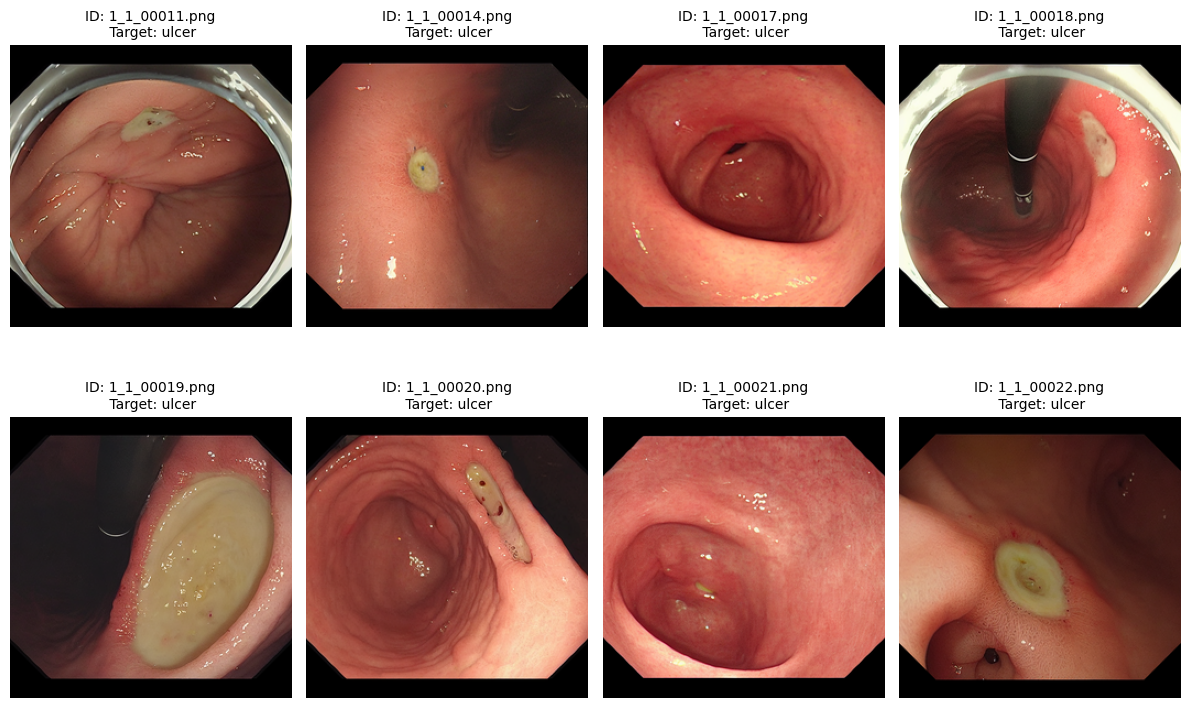

In [ ]:
ROWS = 2; COLS = 4; BATCHES = 1

gen = GastroGenerator(train_df, transforms=get_train_transform())

plt.figure(figsize=(12,8))

for i, (x,y) in enumerate(gen):
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            image_id = train_df.iloc[i*CFG.batch_size+j*COLS+k]['image_id']
            target = train_df.iloc[i*CFG.batch_size+j*COLS+k]['lesion']
            plt.title(f'ID: {image_id}\n Target: {target}', size=10)
            img = x[j*COLS+k,]
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean

            plt.imshow(img)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    if i == BATCHES - 1: break


## 4. Build EfficientNet Model
___

In [ ]:
def build_model():
    feature_only = efn.EfficientNetB0(include_top=False, weights='imagenet', input_shape=None)

    inp = layers.Input(shape=(CFG.img_size[0], CFG.img_size[1],3))
    x = feature_only(inp)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.BinaryCrossentropy(label_smoothing=CFG.label_smoothing)
    opt = optimizers.AdamW(learning_rate=CFG.base_lr, weight_decay=CFG.weight_decay,
                           use_ema=CFG.ema, name='adamw')

    model.compile(loss=loss, optimizer=opt)

    return model

**Model Architecture**

In [ ]:
K.clear_session()
model = build_model()
model.summary()

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnet-b0 (Functional)         │ (None, 8, 8, 1280)          │       4,049,564 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,053,407 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,016 (164.12 KB)

**CallBack**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', patience=2)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_delta=0.01,
                       min_lr=CFG.min_lr, mode='min', verbose=0)

## 5. Train EfficientNet Model
___

In [ ]:
all_history = defaultdict(list)

train_gen = GastroGenerator(train_df[train_df['fold'] != CFG.fold], batch_size=CFG.batch_size, shuffle=True, transforms=get_train_transform())
valid_gen = GastroGenerator(train_df[train_df['fold'] == CFG.fold], batch_size=CFG.batch_size*2, shuffle=False, transforms=get_valid_transform())

K.clear_session()
with strategy.scope():
    model = build_model()
    history = model.fit(train_gen, verbose=1, validation_data=valid_gen,
                            epochs=CFG.num_epochs, callbacks=[lr, es])
    model.save_weights(f'{CFG.output_dir}/best_effnet.weights.h5')
    all_history['lr'].extend(history.history['learning_rate'])
    all_history['train_loss'].extend(history.history['loss'])
    all_history['valid_loss'].extend(history.history['val_loss'])

pred = model.predict(valid_gen, verbose=1)
true = train_df[train_df['fold'] == CFG.fold][TARGET].values

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 288ms/step - loss: 0.4131 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - loss: 0.1941 - val_loss: 0.2467 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.1610 - val_loss: 0.2337 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 0.1662 - val_loss: 0.2052 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - loss: 0.1473 - val_loss: 0.2171 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - loss: 0.1412 - val_loss: 0.1833 - learning_rate: 1.0000e-04
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 0.1273 - val_loss: 0.1876 - learning_rate: 1.0000e-04
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - loss: 0.1276 - val_loss: 0.1844 - learning_rate: 1.0000e-05
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step


**Train Loss, Valid Loss**

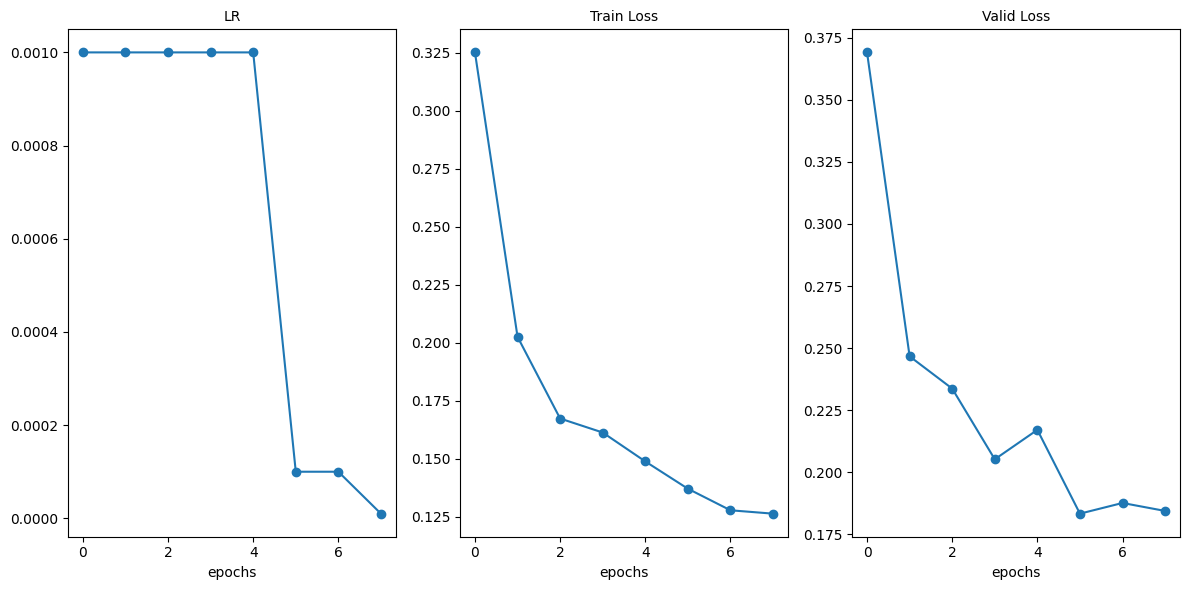

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title('LR', size=10)
plt.plot(all_history['lr'], marker='o')
plt.xlabel('epochs')

plt.subplot(1,3,2)
plt.title('Train Loss', size=10)
plt.plot(all_history['train_loss'], marker='o')
plt.xlabel('epochs')


plt.subplot(1,3,3)
plt.title('Valid Loss', size=10)
plt.plot(all_history['valid_loss'], marker='o')
plt.xlabel('epochs')

plt.tight_layout()
plt.show()

**Metric**

In [ ]:
threshold = 0.5
pred_thr = (pred >= threshold).astype(int)

for i in range(len(TARGET)):
    precision = precision_score(true[:,i], pred_thr[:,i], average='binary')
    recall = recall_score(true[:,i], pred_thr[:,i], average='binary')
    accuracy = accuracy_score(true[:,i], pred_thr[:,i])

    print(f'{Fore.BLUE}#'*25)
    print(f'Class: {TARGET[i]}')
    print(f'#'*25)
    print(f'{Fore.BLACK}Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {accuracy}')
    print('\n')

#########################
Class: ulcer
#########################
Precision: 0.9397590361445783
Recall: 0.975
Accuracy: 0.978125


#########################
Class: polyp
#########################
Precision: 0.972972972972973
Recall: 0.9
Accuracy: 0.96875


#########################
Class: cancer
#########################
Precision: 0.95625
Recall: 0.95625
Accuracy: 0.95625




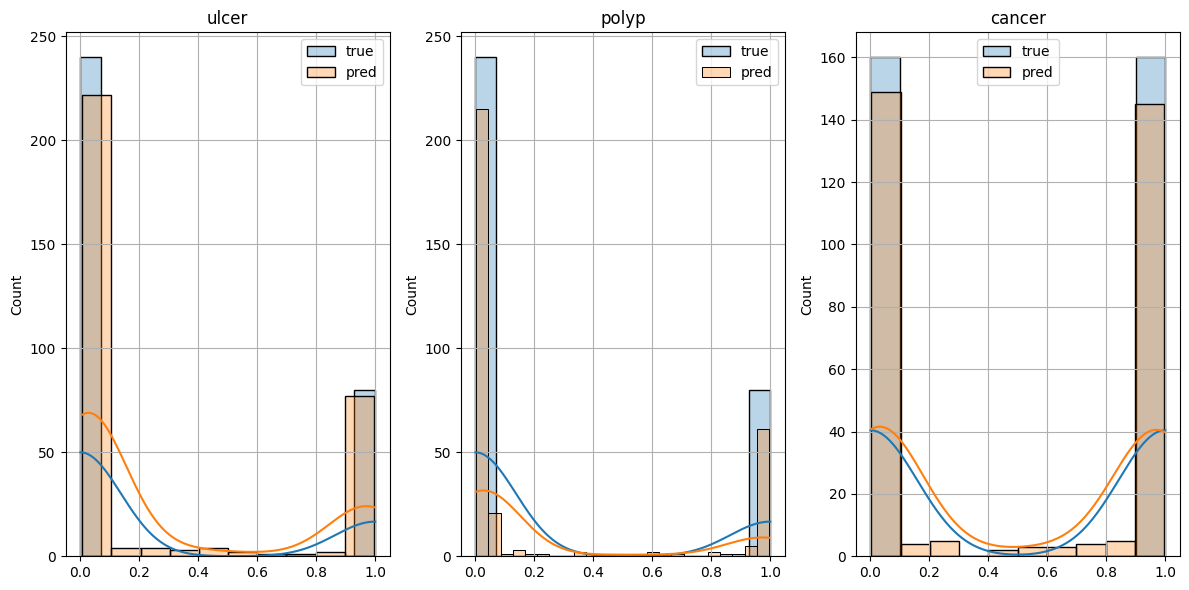

In [ ]:
plt.figure(figsize=(12,6))

for i in range(len(TARGET)):
    plt.subplot(1,3,i+1)
    plt.title(TARGET[i])
    sns.histplot(true[:,i], alpha=0.3, kde=True, label='true')
    sns.histplot(pred[:,i], alpha=0.3, kde=True, label='pred')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Inference
___

In [ ]:
test_gen = GastroGenerator(test_df, batch_size=CFG.batch_size*2, shuffle=False, transforms=get_valid_transform())

K.clear_session()
with strategy.scope(): model = build_model()

model.load_weights(f'{CFG.output_dir}/best_effnet.weights.h5')

test_pred = model.predict(test_gen, verbose=1)
test_true = test_df[TARGET].values

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step


In [ ]:
threshold = 0.5
test_pred_thr = (test_pred >= threshold).astype(int)

for i in range(len(TARGET)):
    precision = precision_score(test_true[:,i], test_pred_thr[:,i], average='binary')
    recall = recall_score(test_true[:,i], test_pred_thr[:,i], average='binary')
    accuracy = accuracy_score(test_true[:,i], test_pred_thr[:,i])

    print(f'{Fore.BLUE}#'*25)
    print(f'Class: {TARGET[i]}')
    print(f'#'*25)
    print(f'{Fore.BLACK}Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {accuracy}')
    print('\n')

#########################
Class: ulcer
#########################
Precision: 0.9797979797979798
Recall: 0.97
Accuracy: 0.9875


#########################
Class: polyp
#########################
Precision: 0.979381443298969
Recall: 0.95
Accuracy: 0.9825


#########################
Class: cancer
#########################
Precision: 0.9702970297029703
Recall: 0.98
Accuracy: 0.975




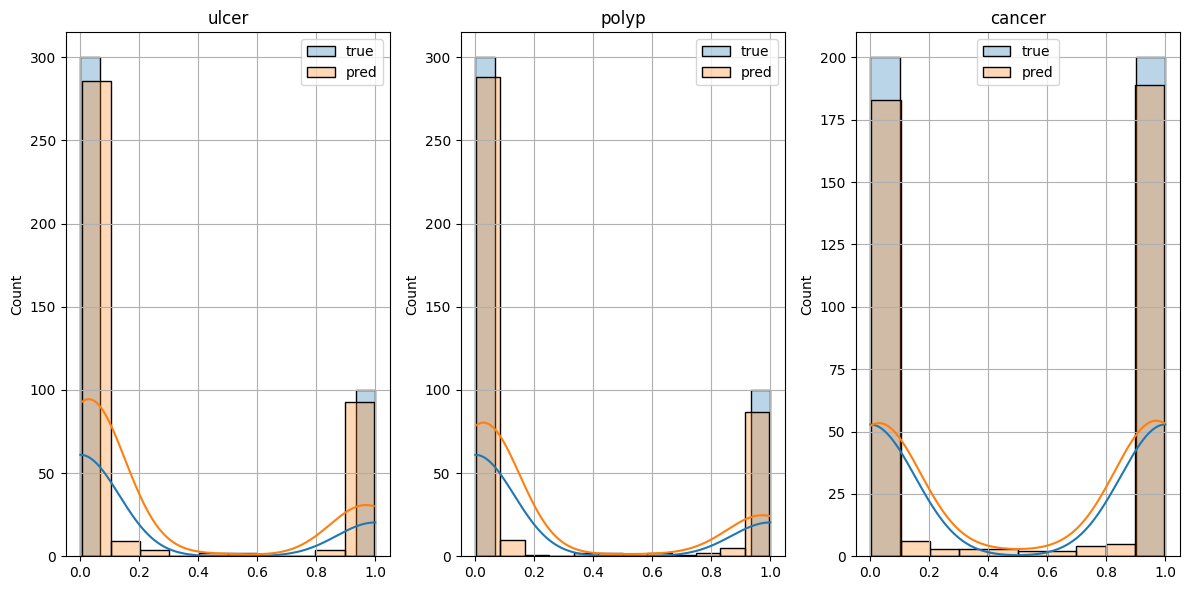

In [ ]:
plt.figure(figsize=(12,6))

for i in range(len(TARGET)):
    plt.subplot(1,3,i+1)
    plt.title(TARGET[i])
    sns.histplot(test_true[:,i], alpha=0.3, kde=True, label='true')
    sns.histplot(test_pred[:,i], alpha=0.3, kde=True, label='pred')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
pred_df = pd.DataFrame(test_pred)
pred_df = pred_df.rename(columns={0: 'ulcer', 1: 'polyp', 2: 'cancer'})
pred_df['image_id'] = test_df['image_id'].values

print(display(pred_df))

,ulcer,polyp,cancer,image_id
0,0.967364,0.035951,0.038746,1_1_00030.png
1,0.180033,0.924693,0.026148,1_1_00033.png
2,0.961043,0.031087,0.036898,1_1_00035.png
3,0.983636,0.025277,0.014472,1_1_00040.png
4,0.979165,0.022631,0.025413,1_1_00095.png
...,...,...,...,...
395,0.017086,0.018231,0.987001,1_3_09783.png
396,0.016761,0.034884,0.980200,1_3_09808.png
397,0.011272,0.011916,0.987444,1_3_09826.png
398,0.019842,0.009413,0.990747,1_3_09872.png


None


In [ ]:
pred_df.to_csv('submission.csv', index=False)